# **After popcorn: Study of movie and show public reception in various platforms.**

Emma Fraxanet Morales. u188703

David Moreno Esteban. u114148

# Introduction

The aim of this project is to provide a broad understanding on how mainstream audiovisual content is perceived by the audience on the internet. 

It is known that people feels more free when expressing their opinions on the social networks or virtual forums rather than expressing them face to face. It would also be a cheaper approach, both economically and energetically, for audiovisual content platforms such as Netflix to rate the success of a show or a movie by a study of this kind rather than paying for the developement and distribution of polls. In the long run this could also help in taking more voices into account when considering whether a show will continue or will be cancelled, since at the moment the platforms are putting a pause on shows that have a great and relevant response in social media. However, the methods used have to be finely tuned in order to produce the desired results.

This projects combines different parts that correspond to the different skills and topics we covered in the Web Intelligence class. The first idea is to detect a relevant weekly show in the Twitter platform through a topic modelling analysis and proceed to analyse the reception of said show. This analysis also contains the indirect assumption that for this show people prefer to watch it at the pace it is being released, instead of binge watching it. 

The second idea is to capture the differences in the opinions expressed regarding mainstream movies taking into account the platform where they have been posted. 

Finally, fo the third part the main concept is to analyse how do people react to movies that contain specific knowledge, being it scientific or historical, through the correlation between the respective pageviews behaviour through time in wikipedia. This gives an idea on the the impact of the films in the search of topics related to them. For example, for the movie Tenet we wondered if people tried to understand what entropy was more often during the release of the movie. This is interesting because the choice of topics in a film or a show can have an impact on society's interests, and for that you just have to see how many more chess boards have been sold after the show The Queen's Gambit.

# Data gathering

## Twitter streaming

In [ ]:
!pip install tweepy

In [ ]:
import tweepy
import json
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy.streaming import StreamListener
 

class MyListener(StreamListener):
    
    def __init__(self, api=None, max_tweets=10, json_tweets_file=None):
        super(StreamListener, self).__init__()
        self.num_tweets = 0
        self.max_tweets = max_tweets
        self.json_tweets_file = json_tweets_file

    def on_data(self, data):
        try:
            with open(self.json_tweets_file, 'a') as f:
                f.write(data) # This will store the whole JSON data in the file, you can perform some JSON filters
                twitter_text = json.loads(data)['text'] # You can also print your tweets here
                print(twitter_text.replace('\n',' ').replace('\r',' '))
                self.num_tweets += 1
                if self.num_tweets < self.max_tweets:
                    return True
                else:
                    return False
        except BaseException as e:
            print("Error on_data: %s" % str(e))
        return True

    def on_error(self, status):
        print('Error :', status)
        return False

# Change the xxx values with your keys
consumer_key = 'xxxxxxxxxx'
consumer_secret = 'xxxxxxxxxxx'
access_token = 'xxxxxxxxxxxxxxxxxxxx'
access_secret = 'xxxxxxxxxxxxxxxxxxxxxxxx'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)        

In [ ]:
keywords = ["wandavision","WandaVision"]
json_tweets_file = 'wandavision'+'5MAR'+'.jsonl'
# You can increase this value to retrieve more tweets but remember the rate limiting
max_tweets = 3000
twitter_stream = Stream(auth, MyListener(json_tweets_file = json_tweets_file, max_tweets = max_tweets))

# Add your keywords and other filters
twitter_stream.filter(track=keywords, languages=['en']) 

print('_______ End _______')

In [ ]:
import pandas as pd

with open(json_tweets_file) as f:
    lines = f.read().splitlines()

df_inter = pd.DataFrame(lines)
df_inter.columns = ['json_element']    
df_inter['json_element'].apply(json.loads)
df = pd.json_normalize(df_inter['json_element'].apply(json.loads))
print (len(df),'tweets')
df.head(10)

## Twitter: Retrieving old tweets

We had to use Cursor to obtain some tweets form past episodes of Wandavision, within the time conmstraints Twitter API has.

In [ ]:
import tweepy
import json
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy.streaming import StreamListener
consumer_key = 'xxxxxxxxxxxxxxxxxxxxxxxx'
consumer_secret = 'xxxxxxxxxxxxxxxxxxxxxxxxx'
access_token = 'xxxxxxxxxxxxx-xxxxxxxxxxxxxxxxxxxx'
access_secret = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)      

api = tweepy.API(auth)
search_results = api.search(q="wandavision", count=500, since_id = 1357472308546457600 ) # este id es del dia 5 (sabado)

In [ ]:
# setting upt the "manual" filter alonmg with the query
query = '#malcomandmarie  since:2021-02-05 until:2021-02-07'
filename = 'cursor_malcomandmarieafte.jsonl'

for tweet in tweepy.Cursor(api.search, q=query, lang="en").items(200):
  with open(filename, 'a') as f:
    json_string = json.dumps(tweet._json)
    f.write(json_string)
    f.write("\n")

## YouTube video comments

Using the YouTube API, we collect the comments of specific videos from well known channels, which are profesional reviewers, with millions of visualizations. For each movie, we retrieve the comments of their review of the 3 channels.

In [ ]:
!pip install youtube-data-api

As we want to contrast different platform, is important to know that the video talks specifically about a movie review. That's why we have chosen channels which are specialized in this, and, hence, we have particular video IDs to get the comments. 

In [ ]:
from youtube_api import YouTubeDataAPI
import pandas as pd

api_key = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxx'
yt = YouTubeDataAPI(api_key)

# Better organization to execute directly by film
video_ids = {
    # 0:chris stuckman, 1:jeremy jahns, 2:beyond the trailer
    'tenet':      ['8gXQsAea26I', 'i358Rws1SV0', 'UJEJRV4tors'], 
    'irishman':   ['byIKRgihYrU', 'qGO5-j3TXJA', 'qAS6-MGSAao'], 
    'wonderwoman':['D2AjToBel_Y', 'MxEwMFe7hvc', 'NMMsjhmgXk0'],
    'bladerunner':['E6eRA8PnuW4', '4kX7iBnoivA', 'JLazQEBMkK8'],
    'the_martian':['Qypj9LrOpio', 'npqN59tlPDg', 'ZqEos6s7c4Y'],
    'endgame':    ['VlYvrkuMGPE', 'dbsGMZh3pRQ', 'QWbYaTxjDj4'],
    'dunkirk':    ['2SglFUPQVnM', 'OS0K_dwdZU0', 'xu6B94cslT4'],
    'once_upon':  ['bjEeBRiulI0', 'k6qBCDMof5s', 'Cl7WqBCUbMo']
    }
n_channels = 3
# Some of them fail, by some unknown reason (maybe a deleted comment, or a banned one) 
# and we have to fix the max_results param
max_results = {
    'tenet':      [400,None, None], 
    'irishman':   [None, None, None], 
    'wonderwoman':[None, None, None],
    'bladerunner':[None, None, None],
    'the_martian':[None, None, None],
    'endgame':    [None, None, None],
    'dunkirk':    [None, None, None],
    'once_upon':  [None, None, None]
    }

current_movie = 'wonderwoman'
# cumulative_df will store the comments of the 3 channels for a single movie
cumulative_df = pd.DataFrame()

for i in range(n_channels):
  url = video_ids[current_movie][i]
  max = max_results[current_movie][i]
  if max is not None:
    r = yt.get_video_comments(url, get_replies=False, max_results=max)
  else:
    r = yt.get_video_comments(url, get_replies=False)

  df = pd.DataFrame(r)
  cumulative_df = pd.concat([cumulative_df, df], ignore_index=True)
  print(cumulative_df.shape)

cumulative_df.head()

(13878, 12)
(19659, 12)
(21386, 12)


,video_id,commenter_channel_url,commenter_channel_id,commenter_channel_display_name,comment_id,comment_like_count,comment_publish_date,text,commenter_rating,comment_parent_id,collection_date,reply_count
0,D2AjToBel_Y,http://www.youtube.com/channel/UCixdnoVimXRKq2...,UCixdnoVimXRKq2NqHimwC_g,Dirk Digglah,Ugzbrdn9s07Y2MSSxfd4AaABAg,0,1.615214e+09,5 minutes into this film and I lost interest w...,none,None,2021-03-08 17:12:22.416684,0
1,D2AjToBel_Y,http://www.youtube.com/channel/UCBNbV2u49xY8ZP...,UCBNbV2u49xY8ZP9ne_r7ixg,Harsh Bhardwaj,UgwMNjtNN70vI2DLwAV4AaABAg,0,1.615192e+09,"The fact that i watched it in 3 days, shows ho...",none,None,2021-03-08 17:12:22.416727,0
2,D2AjToBel_Y,http://www.youtube.com/channel/UCFo-WBUXgBfGe5...,UCFo-WBUXgBfGe51eZNJx-dg,Zee,UgzP7teiaWdVWM5SnaV4AaABAg,1,1.615109e+09,the movie bored me honestly.,none,None,2021-03-08 17:12:22.416752,0
3,D2AjToBel_Y,http://www.youtube.com/channel/UCAmqwSKZyfbybw...,UCAmqwSKZyfbybwTCkTrXZEw,TechMeister1993,UgytPXxOZNwFSqc0GN54AaABAg,0,1.615105e+09,One issue I had with the movie was diana never...,none,None,2021-03-08 17:12:22.416775,0
4,D2AjToBel_Y,http://www.youtube.com/channel/UCayUIHF2dbkCav...,UCayUIHF2dbkCavxIizlV4IQ,NewToTheLyte,UgxfmcLMc5eCsyt9eZZ4AaABAg,0,1.615100e+09,If a collab between Chris and RLM ever happene...,none,None,2021-03-08 17:12:22.416795,0


## Reddit official post comments

From the official posts of the movies reviews, we collect the comments of such posts.

In [ ]:
!pip install praw

     |████████████████████████████████| 163kB 5.7MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 


Firstm we create an only-read instance of the Reddit instance. Then we define the links we want to analyze, to automatize a little bit the process. These links are only Official Discussions from reddit. Once we get the submission, it contains the main post, the comments...

In [ ]:
import praw
from praw.models import MoreComments
import pandas as pd

reddit_urls = {
    'tenet': 'https://www.reddit.com/r/movies/comments/iha5an/official_discussion_tenet_international_thread/',
    'irishman': 'https://www.reddit.com/r/movies/comments/e2149d/official_discussion_the_irishman_spoilers',
    'wonderwoman': 'https://www.reddit.com/r/movies/comments/kkbdpg/official_discussion_wonder_woman_1984_spoilers/',
    'engame': 'https://www.reddit.com/r/movies/comments/bh8iei/official_discussion_avengers_endgame_spoilers/',
    'bladerunner': 'https://www.reddit.com/r/movies/comments/74k6lc/official_discussion_blade_runner_2049_spoilers/',
    'dunkirk': 'https://www.reddit.com/r/movies/comments/6ol0kp/official_discussion_dunkirk_spoilers/',
    'once_upon': 'https://www.reddit.com/r/movies/comments/chmknk/official_discussion_once_upon_a_time_in_hollywood/',
    'the_martian': 'https://www.reddit.com/r/movies/comments/3n6gji/official_discussion_the_martian_spoilers/',
}

reddit = praw.Reddit(
    user_agent="Comment Extraction (by u/username)",
    client_id="xxxxxxxxxxxxxxxxx",
    client_secret="xxxxxxxxxxxxxxxxxxx",
)

url = reddit_urls['the_martian']
submission = reddit.submission(url=url)

comment_texts = []
comment_ids = []

for top_level_comment in submission.comments.list():
  # avoid "More comments" comments (they are between comments)
  if isinstance(top_level_comment, MoreComments):
      continue
  comment_texts.append(top_level_comment.body)
  comment_ids.append(top_level_comment.id)

df = pd.DataFrame (comment_ids,columns=['comment_id'])
df['text'] = pd.Series(comment_texts)
df.shape

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



(497, 2)

## IMDB film reviews

The code doesn't work in collab. However, we attach a notebook to exemplify the procedure.

See imdb.ipynb Notebook



# Sentiment Analysis

In this section we analyze and discuss several things:

*   Sentiment analysis for individual datasets.
*   The reception of the different episodes of Wandavision in Twitter considering the sentiment analysis of each of them.
*   The differeces in the reception of films in different platforms (YouTube, Reddit and IMDB).

## Individual dataset analysis

The linked notebook performs the sentiment analysis for individual datasets, such as single episodes for Wandavision, or YouTube comments from films (also for Reddit and IMDB). Hence, we have run this code for every single dataset extracted from each resource (Twitter for Wandavision, YouTube, Reddit and IMDB for the film analysis). In the link there is the code to execute a single one. Also, it is commented considering the particular results of the episode analyzed.

See Wandavision_SentimentAnalysis.ipynb

## Wandavision: Evolution along episodes

Here we load the metrics that we have been collecting episode by episode from the Sentiment Analysis noteobook (linked previously), and we have put together manually to be able to compute the following metrics. The dataframe is quiet self explanatory, but the main data we can observe is: 


*   Compound mean and variance
*   Number of positive, negative and neutral tweets
*   Mean and variance of the number of positive words per tweet



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/PATH/TO/file.csv')
df.set_index('Episode', inplace=True, drop=True)
df.head(7)

,num_tweets,compound mean,compound var,#tweets Pos,#tweets Neg,#tweets Neu,#pos_words/tweet mean,#pos_words/tweet variance
Episode,,,,,,,,
Ep3,100,0.130,0.180,48,18,34,0.980,1.757
Ep4,1000,0.045,0.108,293,173,534,0.554,0.542
Ep5,2000,0.116,0.149,815,354,831,0.717,0.828
Ep6,3000,0.091,0.141,1044,510,1446,0.609,0.663
Ep7,3000,0.101,0.138,1108,514,1378,0.627,0.716
Ep8,3000,0.015,0.170,1058,943,999,0.685,0.667
Ep9,3000,0.092,0.144,1180,682,1138,0.766,1.033


Taking into account the mean compound value of each chapter, we plot the mean and also the variance the values of all the retrieved tweets per episode. The variance is important, as could show up discrepancy in Twitter opinions. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


<Figure size 1080x648 with 0 Axes>

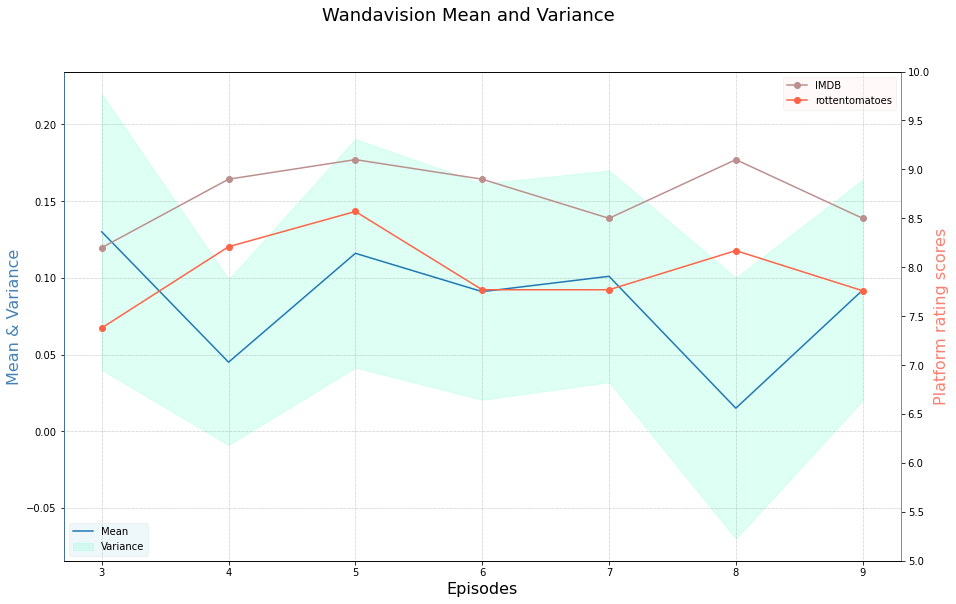

In [ ]:
labels = ['Ep3','Ep4','Ep5','Ep6','Ep7','Ep8', 'Ep9']

fig = plt.figure(figsize = (15,9))
y = df['compound mean'].tolist()
var = df['compound var'].tolist()
x = np.arange(3,10)
var_array = np.array(var)
error = var_array/2
imdb = [8.2,8.9,9.1,8.9,8.5,9.1,8.5]
rot = [7.38,8.21,8.57,7.77,7.77,8.17,7.76]
rating = [8.2,8.9,9.2,8.9,8.5,9.1,8.6]

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
fig.set_figheight(9)
fig.set_figwidth(15)
# make a plot
ax.plot(x, y, label='Mean')
ax.fill_between(x, y-error, y+error, color='aquamarine', alpha=0.25, label='Variance')
# set x-axis label
ax.set_xlabel('Episodes',fontsize=16)
# set y-axis label
ax.set_ylabel('Mean & Variance',color='steelblue',fontsize=16)
fig.suptitle('Wandavision Mean and Variance',fontsize=18)
ax.grid(linestyle='dotted', linewidth='0.5', color='grey')
ax.set_xticks([3,4,5,6,7,8,9], labels)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(x, imdb,color="rosybrown",marker="o",label='IMDB')
ax2.plot(x, rot,color="tomato",marker="o", label='rottentomatoes')
ax2.set_ylabel("Platform rating scores",color="salmon",fontsize=16)
ax2.set_yticks(np.arange(5,10.5,0.5))

ax.legend(loc = 'lower left',facecolor= 'lightblue',framealpha=0.2)
ax2.legend(loc = 'upper right',facecolor= 'mistyrose',framealpha=0.2)
ax2.spines["left"].set_color("steelblue")
ax2.spines["right"].set_color("salmon")
plt.show()

Here we observe 2 things: the first one is the mean and the variance of the compound value along the Wandavision episodes. The second thing we observe are ratings in two different sites, IMDB and rottentomatoes. It is important to have in mind that the ranks in IMDB are quite biased by inner filters they apply to the comments, se we cannot conclude anything from this rank due to the opacity of such filters. 

It is easy to see that they both differ from the mean extracted from Twitter, specially in the episode 4 and 8, where there is a complete discrepancy between the twitter mean and the ratings. In fact, for these two episodes, both rating are even out of the variance area. Also the third one differs, but not so dramatically. 

Now we analyze the number of tweets per each "emotion" in each chapter.

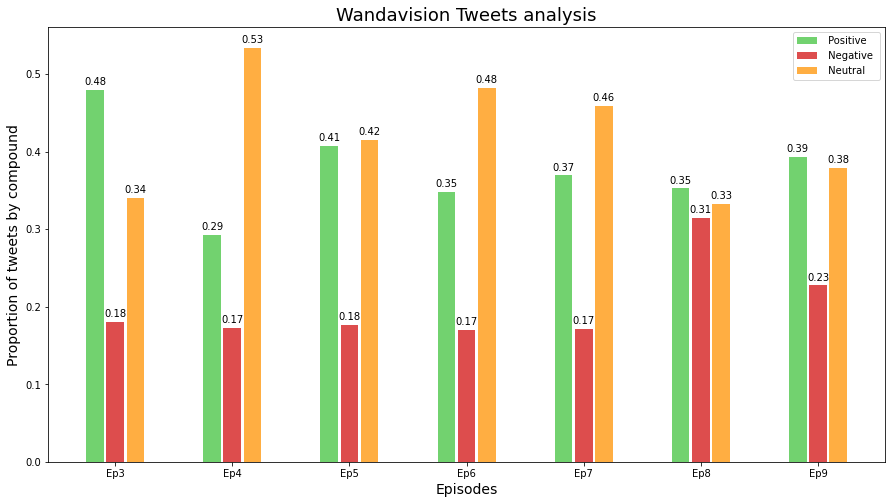

In [ ]:
labels = ['Ep3','Ep4','Ep5','Ep6','Ep7','Ep8', 'Ep9']
x = np.arange(len(labels))
num_tweets = df['num_tweets'].to_numpy()
# pos_tweets is the real number
pos_tweets = df['#tweets Pos'].to_numpy()
# pos_prop is the proportion (pos_tweets/all_tweets)
pos_prop = [i / j for i, j in zip(pos_tweets, num_tweets)]

neg_tweets = df['#tweets Neg'].to_numpy()
neg_prop = [i / j for i, j in zip(neg_tweets, num_tweets)]

neu_tweets = df['#tweets Neu'].to_numpy()
neu_prop = [i / j for i, j in zip(neu_tweets, num_tweets)]

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(15)
width = 0.15
pos_bar = ax.bar(x - width*1.15, pos_prop, width, color='#72D26F',label=' Positive ')
neg_bar = ax.bar(x ,  neg_prop,  width, color='#DD4D4D', label=' Negative ')
neu_bar = ax.bar(x + width*1.15,  neu_prop,  width, color='#FFAE42', label=' Neutral ')
ax.set_ylabel('Proportion of tweets by compound', fontsize=14)
ax.set_xlabel('Episodes', fontsize=14)
ax.set_title('Wandavision Tweets analysis', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(float(round(height,2))),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(pos_bar)
autolabel(neg_bar)
autolabel(neu_bar)

## Film reception analysis

For this section, we aimed to compare how the users of different platforms such as YouTube, REeddit or IMDB received different films. To carry out this study, we have chosen the highest grossing films of the recent years, to ensure a high activity on those platforms: 
*  Tenet
*  The Martian
*  Bladerunner 2049
*  Avengers: Endgame
*  Dunkirk
*  Once upon a time in Hollywood
*  The irishman

Some of the evaluation metrics carried out inside the linked notwbook are:

1.   Mean and variance of the compound value given by VADER per platform.
2.   Number of positive, negative and neutral comments per platform. 
3.   Proportion of positive, negative and neutral words per comment.

To access this section we provide a link to the notebook where everything is presented and explained:

See MetricsFilmsDifferentPlatforms.ipynb

# Topic modelling

For this section we perform a topic modelling analysis to different datasets of tweets containing ['movie premiere','new movie','new episode', 'new film']. Our idea is to prove that we are able to detect topics related to new releases on that week. The number of topics has to be determined from a coherence score so that a specific movie/show/episode release is contained within a single topic and not sparsed through topics.

We use three different datasets from three different fridays. We find different optimal number of topics for each one, with some topics that are well defined and other that are more general. In conclusion we clearly see that the new Wandavision episode release is always one of the well defined topics. This denotes how the reception of the series in Twitter is relevant, and justifies our studies on it.

Here we attach the link to three notebooks: one for each dataset.

- 5 March = See TOPIC_MODELLING_PREMIERE_5_mar.ipynb file
- 19 February = See TOPIC_MODELLING_PREMIERE_5_feb.ipynb file
- 5 February =  See TOPIC_MODELLING_PREMIERE_19_feb.ipynb file

Most of the code was provided by the lab session on the "Topic Modelling" lecture. However, there are some changes to adapt the procedure to our datasets. For example, we do a previous study on most and least frequent words.

This procedure cleans the text from the least used words, the usernames, the usual stopwords (with specific twitter words such as 'https','rt', and 'co') and the words that are directly from the search. It also creates and applies bigram and trigram models and lemmatizes the text. Finally, it applies and LDA Mallet Model, that together with a coherence study, returns the optimal number of topics and their keywords. We save the obtained topics.

Finally, we also do some checking on the model and we review the dominant topics in different tweets and the representative tweets for each topic.

# Correlation wikipedia pageviews

In this notebook we provide the code to obtain the pageview information of different movies and science/historical/general topics present in their wikipedia article. Then we also provide the results for a correlation study between these variables.

Our idea is to define how the release of some films can affect the curiosity of the viewers and make them investigate further on specific topics. For example, entropy is a very general scientific topic but it is highly correlated to the pageviews on the movie Tenet.


To access this section we provide a link to the notebook where everything is presented and explained:

See correlationwiki.ipynb

SUMMARY OF THE RESULTS:

For science/technology/sci-fi topics in movies we find some succesful results (Tenet and entropy, Arrival and palindrome) but also find no results for other movies, probably because the term is either too general, too popular or both (The Martian, Blade Runner 2049 and Spider-Man).

The case of The Martian is curious because Mars got a lot of visits a day before the release of The Martian because of the discovery of running water on the planet around that date, which changed the behaviour in the wikipedia visits.

We find high correlation between historically based/inspired movies and the specific individuals, places and explanations regarding the original topic. This is the case for the movies The Two Popes, The Trial of the Chicago 7, Once Upon a Time in Hollywood, 1917 and The Queen's Gambit. In some cases the link was very direct (the main character was a public figure) and some times the link is not that obvious (for example, the Black Panther Party page and The Trial of the Chicago 7 movie, where it is mentioned but it is not the central topic, and the Manson Family in Once Upon a Time in Hollywood, which are not directly mentioned but are a strong inspiration ). 

# Conclusion and Future Work

Individual conclsuions of each section have been provided inside them. To summarize a bit all the conclusions, after all the process detailed above, the data gathering, the analysis, the correlation impact... we could state, based on the results, the following things: 

1.  Sometimes, the social network users' opinion does not coincide with the movie/show rating in specialized pages such as IMDB or RottenTomatoes. In fact, some times, neither the analyzed opinion in filmaking oriented platforms coincide with the same platform's rating. As we have observed, comments in social network platforms tend to produce a more neutral sentiment result. This migh be due to the usage of a unusual language such as slang words, or the use of irony.

2.  Regarding IMDB, it has been hard to deduce the reason of some results. We have concluded that the origin of some unexpected results, such as the dramatic fall of Avengers: Endgame, is due to the fact that IMDB reviews normally include a brief summary of the film, which biases the overall sentiment analysis towards the sentiment provoced within the explanation of the film context.

3.  Films with high impact on the cinemas/streaming platforms have an impact on the web research in specific topics featured in the film.  We found highly correlated pageviews. Though we know correlation does not mean causality, the fact that the topics we studied are linked in the movie's wikipedia page, and that for a big proportion of the films there was a high correlation result, makes us think that it is safe to infer this is a cause-effect situation. For example, Tenet and entropy have a high correlation, even if entropy is a quite general term that is studied in several scientific disciplines, the release of the movie boosted the searches on it to higher pageviews than the average value. In our results we also find cases in which there was not any correlation. In most cases the topic was too general or something else happened at the time that made it more popular.

Regarding the **future work**, we have some clear parts that we would have liked to improve if we have had more time: 

1.  A better data cleaning / sentiment analysis: analyze deeply which are the words that might bias or distort the sentiment analysis. This is hard to perform, because in the case a film is about death or sadness, a review could  want to express execlence, but the words death and sadness will boycott  this positive comment in the current analysis. Therefore, removing the "emotional" keywords inherent the context of a movie could be an option. Also, test the analysis with bigrams or trigrams might clarify this dark spots.

2.  Take into account the relevance a comment or a tweet has in the platform to weight the importance in the overall analysis. Probably, the most liked tweets or comments represent more people's opinion (those who do not want to commet, but support that opinion), and we should have this importance reflected on the general polarity of such film or TV show.

3. Detect if there exist a gender bias on the YouTube comments depending on the gender of the youtuber (Chris Stuckman comments vs Beyond the trailer comments). This idea goes in another direction than the main concept but came up during the analysis of the Youtube comments, when we realized women's channels used to have more sexualizing comments directed towards them.